In [63]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Subset

In [85]:
1+1

2

# Make histogram

In [ ]:
lens = []

for i in range(len(dataset)):
    lens.append(len(dataset[i][1]))

In [86]:
len(lens)

127107

In [94]:
lens[1]

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2.])

In [ ]:
plt.hist(lens, bins = 100)
plt.title("Histogram of E. coli read length")
plt.xlabel("Read length")
plt.ylabel("Amount")

# Annotation analyses

## Load datasets

In [ ]:
dataset = torch.load('HX1_train_val_test_split/dataset.pt')

In [ ]:
train_inds = np.load('HX1_train_val_test_split/train_inds.npy')
val_inds = np.load('HX1_train_val_test_split/val_inds.npy')
test_inds = np.load('HX1_train_val_test_split/test_inds.npy')

In [ ]:
len(test_inds) + len(val_inds) + len(train_inds)

In [ ]:
train = Subset(dataset, train_inds)
val = Subset(dataset, val_inds)
test = Subset(dataset, test_inds)

## Load y_hat and y_true data

In [ ]:
#np.save('/home/yarivl/thesis/results/ConvNeXt/HX1/y_hat_test.npy', y_hat_test)
#np.save('/home/yarivl/thesis/results/ConvNeXt/HX1/y_true_test.npy', y_true_test)

y_hat_C = np.load('/home/yarivl/thesis/results/ConvNeXt/HX1/y_hat_test.npy')
#y_hat_T = 
y_true = np.load('/home/yarivl/thesis/results/ConvNeXt/HX1/y_true_test.npy')

## Necessary functions

In [ ]:
def determine_states(y_hat, y_lab):
    #0 = NVT, 1 = TP, 2 = FP, 3 = TN, 4 = FN
    #y_pred = np.round(y_pred)
    #y_hat = np.round(y_hat)
    all_states = []
    all_preds = []
    counter = 0
    for i in range(len(y_lab)):
        states = np.zeros(len(y_lab[i]))
        y_hat_segment = np.zeros(len(y_lab[i]))
        
        mask = y_lab[i] != 2
        y_hat_segment[mask] = y_hat[counter:counter + sum(mask)]
        all_preds.append(y_hat_segment)
        y_hat_pred = np.round(y_hat_segment)
        counter += sum(mask)
                                 
        true = y_lab[i] == y_hat_pred
        false = y_lab[i] != y_hat_pred
        
        positive = y_hat_pred == 1
        negative = y_hat_pred == 0
        nvt = y_lab[i] == 2
    
        states[np.logical_and(true, positive)] = 1
        states[np.logical_and(false, positive)] = 2
        states[np.logical_and(true, negative)] = 3
        states[np.logical_and(false, negative)] = 4
        states[nvt] = 0
        
        all_states.append(states)
    
    return all_states, all_preds
    
def expand_states(y_states):
    TP = y_states == 1
    FP = y_states == 2
    TN = y_states == 3
    FN = y_states == 4
    
    return TP, FP, TN, FN

## Get sequences and labels

In [ ]:
y_lab = []
seqs = []

for i in range(len(test)):
    #get labels
    y_labels = np.array(test[i][1])
    
    y_lab.append(y_labels)
    
    #get sequence
    seq = np.transpose(test[i][0])[3:8, :].detach().numpy()
    seqs.append(seq)

## Determine states for both models

In [ ]:
y_stat_C, y_pred_C = determine_states(y_hat_C, y_lab)
#y_stat_T = determine_states(y_hat_T, y_lab)

## Compare states for both models

In [ ]:
#combine all of them in one object ('TP' instead of boolean)

TP = []
FP = []
TN = []
FN = []

for i in range(len(y_stat_C)):
    [t_TP, t_FP, t_TN, t_FN] = expand_states(y_stat_C[i])
    TP.append(t_TP)
    FP.append(t_FP)
    TN.append(t_TN)
    FN.append(t_FN)

In [101]:
mask = []
for i in range(len(TP)):
    temp = np.logical_or(TP[i], FP[i])
    temp = np.logical_or(temp, TN[i])
    mask.append(np.logical_or(temp, FN[i]))

## Get and clean annotation data

In [35]:
#!genome-build GRCh38.p13
#!genome-version GRCh38
#!genome-date 2013-12
#!genome-build-accession GCA_000001405.28
#!genebuild-last-updated 2021-11

In [102]:
import pandas as pd

features_df = pd.read_csv('/home/yarivl/annotated_HX1/Homo_sapiens.GRCh38.106.gtf', sep = '\t', header = None)
regulatory_features_df = pd.read_csv('/home/yarivl/annotated_HX1/homo_sapiens.GRCh38.Regulatory_Build.regulatory_features.20210107.gff', sep = '\t', header = None)

/home/yarivl/anaconda3/envs/thesis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [103]:
#features_df
for i in range(25):
    features_df.loc[features_df[0] == str(i), 0] = i
    
features_df.loc[features_df[0] == 'X', 0] = 23
features_df.loc[features_df[0] == 'Y', 0] = 24


features_df = features_df[[type(i) == int for i in list(features_df[0])]]


locations = features_df[0].unique()
features = features_df[2].unique()
for loc in locations:
    features_df[0].value_counts()[loc]
    print(loc, ': ', features_df[0].value_counts()[loc])
for fea in features:
    features_df[2].value_counts()[fea]
    print(fea, ': ', features_df[2].value_counts()[fea])

1 :  302348
2 :  250535
3 :  214015
4 :  135118
5 :  145697
6 :  154344
7 :  154394
23 :  111358
8 :  120712
9 :  123725
11 :  196376
10 :  128282
12 :  183554
13 :  54573
14 :  117024
15 :  117814
16 :  147198
17 :  190787
18 :  57446
20 :  77812
19 :  180839
24 :  7944
22 :  69708
21 :  37082
gene :  61461
transcript :  246415
exon :  1572300
CDS :  851019
start_codon :  95242
stop_codon :  88846
five_prime_utr :  168139
three_prime_utr :  195144
Selenocysteine :  119


In [104]:
#regulatory_features_df
for i in range(25):
    regulatory_features_df.loc[regulatory_features_df[0] == str(i), 0] = i
    
regulatory_features_df.loc[regulatory_features_df[0] == 'X', 0] = 23
regulatory_features_df.loc[regulatory_features_df[0] == 'Y', 0] = 24


regulatory_features_df = regulatory_features_df[[type(i) == int for i in list(regulatory_features_df[0])]]


locations = regulatory_features_df[0].unique()
features = regulatory_features_df[2].unique()
for loc in locations:
    regulatory_features_df[0].value_counts()[loc]
    print(loc, ': ', regulatory_features_df[0].value_counts()[loc])
for fea in features:
    regulatory_features_df[2].value_counts()[fea]
    print(fea, ': ', regulatory_features_df[2].value_counts()[fea])

23 :  19474
24 :  987
1 :  54608
2 :  52244
3 :  42511
4 :  33724
5 :  36503
6 :  36057
7 :  34208
8 :  30084
9 :  27414
10 :  29648
11 :  29535
12 :  29428
13 :  17844
14 :  18973
15 :  19893
16 :  19620
17 :  22754
18 :  15143
19 :  15303
20 :  16783
21 :  7877
22 :  10754
CTCF_binding_site :  175885
enhancer :  127935
open_chromatin_region :  110101
promoter :  36597
promoter_flanking_region :  140548
TF_binding_site :  30303


In [105]:
#turn dataframes into np arrays

features_dict = {}
regulatory_features_dict = {}

for i in range(24):
    features_dict[i + 1] = np.transpose(np.array(features_df[features_df[0] == i + 1]))

regulatory_features_dict = {}

for i in range(24):
    regulatory_features_dict[i + 1] = np.transpose(np.array(regulatory_features_df[regulatory_features_df[0] == i + 1]))

#np.savez_compressed(pi_dir, **features_dict)
#np.savez_compressed(pi_dir, **regulatory_features_dict)

## Get annotation data

In [170]:
def annotation(mask, features_dict, inds, preds, labs):
    features = []
    counts = [[], [[]], [[]]]

    #for i in range(len(mask)):
    tresh = 0
    for i in inds:
        #get read location
        chrom = dataset.get_tensors_WGBS_extra(test.indices[i])[2]
        read_start = dataset.get_tensors_WGBS_extra(test.indices[i])[3]
        read_end = dataset.get_tensors_WGBS_extra(test.indices[i])[4]
        orientation = dataset.get_tensors_WGBS_extra(test.indices[i])[5]
        read = mask[i]
        read_preds = preds[i]
        read_labs = labs[i]
        read_index = np.where(read == True)[0]
        read_preds = read_preds[read_index]
        read_labs = read_labs[read_index]

        #indices to genomic coords
        if orientation == '+':
            gen_coords = read_start + read_index + 1
        elif orientation == '-':
            gen_coords = read_end - read_index

        f_dict = features_dict[int(chrom[7:9])]
        
        counter = 0

        #get annotation
        for coor in gen_coords:
            features = np.unique(f_dict[2][(f_dict[3] < coor) & (f_dict[4] > coor)])
            for feature in features:
                if feature in counts[0]:
                    ind = [i for i, val in enumerate(np.array(counts[0]) == feature) if val][0]
                    counts[1][ind].append(read_labs[counter])
                    counts[2][ind].append(read_preds[counter]) # = #counts[2][ind] + read_preds[counter]
                else:
                    counts[0].append(feature)
                    counts[1].append([read_labs[counter]])
                    counts[2].append([read_preds[counter]])
            tresh += 1
            counter += 1

    return counts
  

In [107]:
from time import time

In [108]:
len(test)

12711

In [143]:
inds = list(np.arange(0, 12711))

In [144]:
inds = random.sample(inds, 12711)

In [ ]:
t = time()
annotated_all = annotation(mask, features_dict, inds, y_pred_C, y_lab)
print(time() - t)

In [ ]:
np.save('/home/yarivl/thesis/results/anno/annotated_all.npy', annotated_all)

In [185]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

def eval_anno(y_true, y_hat):
    acc = accuracy_score(y_true, np.round(y_hat))
    prec = precision_score(y_true, np.round(y_hat))
    rec = recall_score(y_true, np.round(y_hat))
    fpr, tpr, thresholds_ROC = roc_curve(y_true, y_hat)
    precision, recall, thresholds_PR = precision_recall_curve(y_true, y_hat)

    #calculate area under the curve
    AUC_ROC = auc(fpr, tpr)
    AUC_PR = average_precision_score(y_true, y_hat)
    
    return AUC_ROC, AUC_PR, acc, prec, rec

In [213]:
eval_anno(annotated_all[1][5], annotated_all[2][5])

(0.955663558989768,
 0.9909373597649985,
 0.9215994962216625,
 0.9321391663796073,
 0.981145757795504)

In [239]:
sum(np.round(annotated_all[1][0]))/len(annotated_all[1][0])

0.9097500396836513

In [240]:
sum(np.round(annotated_all[2][0]))/len(annotated_all[2][0])

0.9211579222573928

In [189]:
len(annotated_all[1][1])

428389

In [249]:
annotated_all_regulatory[0]

['enhancer',
 'open_chromatin_region',
 'promoter',
 'promoter_flanking_region',
 'CTCF_binding_site',
 'TF_binding_site']

In [256]:
from sklearn import metrics
metrics.confusion_matrix(annotated_all_regulatory[1][5], np.round(annotated_all_regulatory[2][5]))

array([[ 221,  197],
       [  52, 2706]])

In [280]:
sum(annotated_all_regulatory[1][5])/len(annotated_all_regulatory[1][5])

0.8683879093198993

In [285]:
np.array(TN_ann2_perc)/(np.array(TN_ann2_perc)+np.array(FN_ann2_perc))

array([0.6074896 , 0.60285714, 0.98980601, 0.75621163, 0.90838959,
       0.80952381])

In [258]:
labels_ann1 = ['gene', 'transcript', 'exon', 'five prime utr', 'CDS', 'three prime utr']
TP_ann1_perc = [384593, 384594, 46911, 1626, 19105, 15615]
FP_ann1_perc = [10020, 10020, 2484, 798, 430, 282]
TN_ann1_perc = [28642, 28642, 10826, 4897, 2124, 629]
FN_ann1_perc = [5133, 5133, 880, 38, 397, 250]

NPV = [0.848024, 0.848024, 0.924825, 0.992300 , 0.842523,
       0.715586]

TNR = [0.740831, 0.740831, 0.813373 , 0.859877, 0.831637, 0.690450]

perc_pos = [0.909750, 0.909750, 0.782164, 0.226118, 0.884204, 0.945696]

In [257]:
labels_ann2 = ['enhancer', 'open chromatin region', 'promoter', 'promoter flanking region', 'CTCF binding site', 'TF binding site']
TP_ann2_perc = [15381, 7695, 9358, 49046, 16528, 2706]
FP_ann2_perc = [292, 156, 6516, 1965, 2129, 197]
TN_ann2_perc = [438, 211, 23012, 2587, 3768, 221]
FN_ann2_perc = [283, 139, 237, 834, 380, 52]

NPV = [0.607490, 0.602857, 0.989806, 0.756212, 0.908390, 0.809524]

TNR = [0.600000, 0.574932, 0.779328 , 0.568322, 0.638969, 0.528708]

perc_pos = [0.955472, 0.955249, 0.245252, 0.916373, 0.741416, 0.868388]

In [ ]:
t = time()
annotated_all_regulatory = annotation(mask, regulatory_features_dict, inds, y_pred_C, y_lab)
print(time() - t)

In [ ]:
np.save('/home/yarivl/thesis/results/anno/annotated_all_regulatory.npy', annotated_all_regulatory)

In [230]:
np.unique(features_dict[1][2])

array(['CDS', 'Selenocysteine', 'exon', 'five_prime_utr', 'gene',
       'start_codon', 'stop_codon', 'three_prime_utr', 'transcript'],
      dtype=object)

In [40]:
import random

In [107]:
np.save('/home/yarivl/thesis/results/anno/TP_ann1.npy', TP_ann1)

In [ ]:
mask = TP

In [51]:
t = time()
TP_ann1 = annotation(TP, features_dict, inds, y_pred_C)
print(time() - t)
#np.save('/home/yarivl/thesis/results/anno/TP_ann1.npy', TP_ann1)

150.26902675628662


In [55]:
np.var(TP_ann1[2][0])

0.00490716146768266

In [56]:
t = time()
TN_ann1 = annotation(TN, features_dict, inds, y_pred_C)
print(time() - t)
#np.save('/home/yarivl/thesis/results/anno/TN_ann1.npy', TN_ann1)

1418.7027323246002


In [57]:
t = time()
FN_ann1 = annotation(FN, features_dict, inds, y_pred_C)
print(time() - t)
#np.save('/home/yarivl/thesis/results/anno/FN_ann1.npy', FN_ann1)

7442.893457651138


In [58]:
t = time()
FP_ann1 = annotation(FP, features_dict, inds, y_pred_C)
print(time() - t)
#np.save('/home/yarivl/thesis/results/anno/FP_ann1.npy', FP_ann1)

3768.9823133945465


In [115]:
1+1

2

In [1]:
TP_ann2_perc = [431, 62, 145, 151, 51, 75] #915

In [2]:
TN_ann2_perc = [362, 25, 50, 555, 2932, 21] #3945

In [3]:
FP_ann2_perc = [646, 50, 99, 701, 2381, 67] #3944

In [4]:
FN_ann2_perc = [523, 86, 170, 223, 143, 34] #1179

In [5]:
labels_ann1 = ['gene/transcript', 'exon', 'three prime utr', 'five prime utr', 'CDS']

In [6]:
[545 + 3196 + 238 + 146 + 23]

[4148]

In [7]:
TP_ann1_perc = [3850, 482, 76, 8, 277] #4693

In [8]:
TN_ann1_perc = [3506, 1362, 58, 698, 255] #5879

In [9]:
FP_ann1_perc = [3540, 872, 95, 293, 126] #4926

In [10]:
FN_ann1_perc = [3196, 545, 146, 23, 238] #4148

In [14]:
import matplotlib.pyplot as plt
import numpy as np

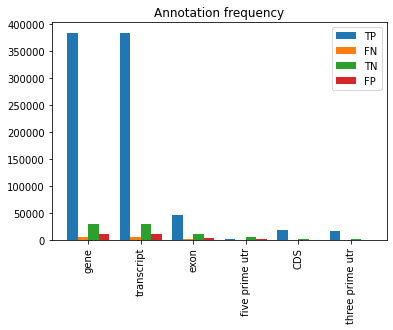

In [259]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

X_axis = np.arange(len(labels_ann1))
  
ax.bar(X_axis - 0.3, TP_ann1_perc, 0.2, label = 'TP')
ax.bar(X_axis - 0.1, FN_ann1_perc, 0.2, label = 'FN')
ax.bar(X_axis + 0.1, TN_ann1_perc, 0.2, label = 'TN')
ax.bar(X_axis + 0.3, FP_ann1_perc, 0.2, label = 'FP')

ax.set_title('Annotation frequency')
plt.xticks(X_axis, labels_ann1, rotation=90)
plt.legend()

plt.show()

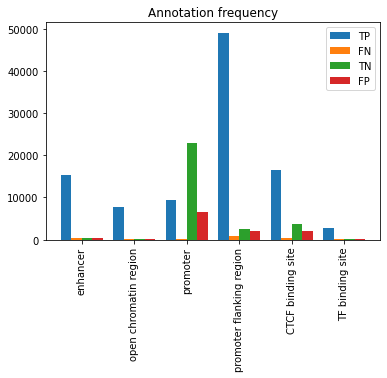

In [260]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

X_axis = np.arange(len(labels_ann2))
  
ax.bar(X_axis - 0.3, TP_ann2_perc, 0.2, label = 'TP')
ax.bar(X_axis - 0.1, FN_ann2_perc, 0.2, label = 'FN')
ax.bar(X_axis + 0.1, TN_ann2_perc, 0.2, label = 'TN')
ax.bar(X_axis + 0.3, FP_ann2_perc, 0.2, label = 'FP')

ax.set_title('Annotation frequency')
plt.xticks(X_axis, labels_ann2, rotation=90)
plt.legend()

plt.show()

<BarContainer object of 6 artists>

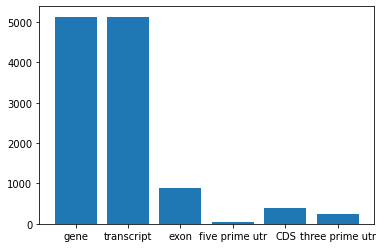

In [266]:
plt.bar(labels_ann1, FN_ann1_perc)

<BarContainer object of 6 artists>

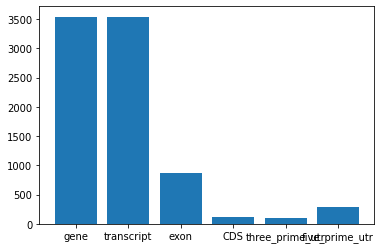

In [125]:
plt.bar(FP_ann1[0], FP_ann1[1])

<BarContainer object of 6 artists>

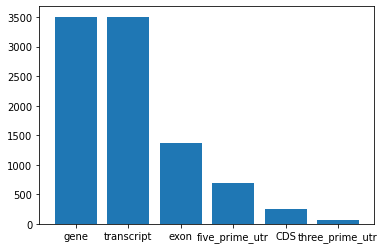

In [126]:
plt.bar(TN_ann1[0], TN_ann1[1])

<BarContainer object of 6 artists>

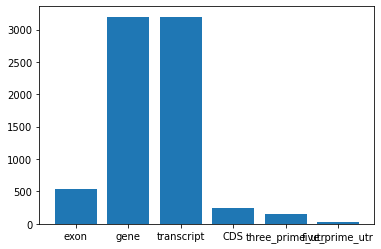

In [127]:
plt.bar(FN_ann1[0], FN_ann1[1])

In [ ]:
#probabilities